# **[GD_2] Project : CutMix 또는 Mixup 비교실험 하기 🌄**

Augmentation은 한정된 데이터셋을 여러가지 방법으로 증강시켜(augment) 실질적인 학습 데이터셋의 규모를 키울 수 있는 방법입니다.  
* 과적합(overfitting) 방지
* 기 보유 데이터셋이 실제 상황에서의 입력값과 다른 경우 실제 입력값과 비슷한 데이터분포를 만들어 낼 수 있음  

## Augmentation의 종류
* Flipping
* Gray Scale
* Saturation
* Brightness
* Rotation
* Center crop
* Blurring
* RandomCrop
* ...

In [120]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


## **0. Data 불러오기**

stanford_dogs 데이터셋을 사용해보겠습니다.  
[stanford_dogs 데이터셋](https://www.tensorflow.org/datasets/catalog/stanford_dogs)  
* 120개 견종의 이미지
* 총 20,580장의 이미지
* 학습 데이터셋 12,000장
* 평가 데이터셋 8,580장


In [122]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    #as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes

다운로드된 데이터 확인

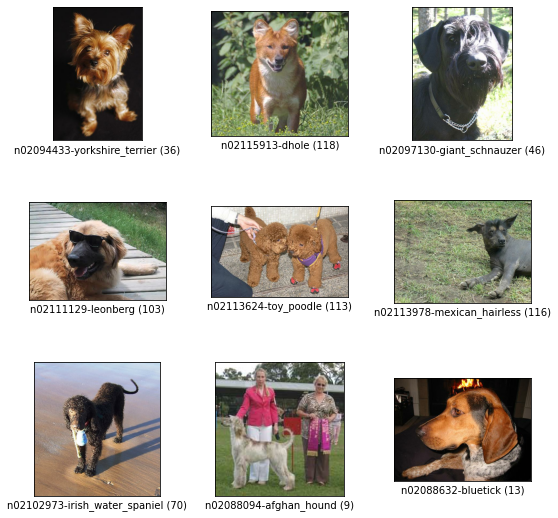

In [123]:
fig=tfds.show_examples(ds_train, ds_info)

## **1. Augmentation을 적용한 데이터셋 만들기**
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

```
Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다.
batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?

👉 CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.
```

### cutmix 함수 구현

In [124]:
# 바운딩 박스 위치 결정함수
# 바탕이미지 image_a, 다른이미지 image_b
def get_clip_box(image_a, image_b, image_size=224):
    # image.shape = (height, width, channel)

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size), tf.int32)

    # get width.. height = width니까
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(image_size*tf.math.sqrt(1-_prob), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-width//2)
    x_max = tf.math.minimum(image_size, x+width//2)
    y_max = tf.math.minimum(image_size, y+width//2)
    
    return x_min, y_min, x_max, y_max


In [125]:
# mix two images
# get_clip_box에서 가져온 변수값들을 이용해서 image 섞기
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max, image_size=224):
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [126]:
# mix two labels
# 이미지 섞었으니까 라벨도 적절한 비율로 섞어주기
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120, image_size=224):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size*image_size
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


In [127]:
# 위의 두 함수를 이용해서 배치단위의 cutmix 함수를 구현
def cutmix(image, label, prob=1.0, batch_size=16, image_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, image_size, image_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### mixup 함수 구현

mixup은 cutmix와 다르게 픽셀값을 비율에 따라 섞어주는 방식

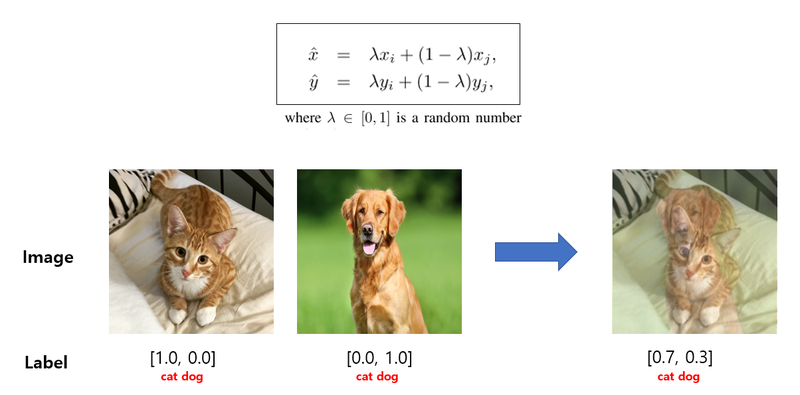

In [128]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [129]:
def mixup(image, label, prob=1.0, batch_size=16, image_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, image_size, image_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### Augmentation 함수

In [130]:
# normalize & resize 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 반전, 밝기조절 적용 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

# 라벨을 클래스 개수만큼 one-hot encoding해줌
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

print('=3')

=3


In [131]:
# dataset에 test인지, augmentation 적용할지, cutmix 적용할지 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        # normalize & resize 함수 적용 
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    # train 데이터에만 augmentation 적용
    if not is_test and with_aug:
        ds = ds.map(
            # augment 함수 적용
            augment,
            num_parallel_calls=2
        )
    # batch 함수
    ds = ds.batch(batch_size)

    # batch함수 뒤에 cutmix온당~

    # train데이터면서 cutmix 적용시
    if not is_test and with_cutmix:
        ds = ds.map(
            # cutmix 적용
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            # cutmix 적용
            mixup,
            num_parallel_calls=2
        )
    else:
        # test데이터
        ds = ds.map(
            # onehot 적용
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        # train 데이터
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


## **2. 모델 만들기**
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

**no augmentation** 적용한 데이터셋으로 학습시킬 resnet50

In [134]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        # FC layer 포함안함
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


**기본 augmentation** 적용한 데이터셋으로 학습시킬 resnet50

In [135]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


**기본+cutmix** 적용한 데이터셋으로 학습시킬 resnet50

In [136]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


**기본+mixup** 적용한 데이터셋으로 학습시킬 resnet50

In [137]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


## **3. 모델 훈련하기**
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

```
Q2. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?

👉 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 
더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문
```

텐서플로우 데이터셋에서 불러온 데이터에 apply_normalize_on_dataset()에서 with_aug를 False로 주면 aug적용x, True로 주면 aug 적용o를 이용하겠습니다.
1. augmentation 적용x  
2. 기본 augmentation 적용o
3. 기본 + cutmix
4. 기본 + mixup

In [138]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


훈련 돌입~

**기본 aug**

In [139]:
EPOCH = 20

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 122ms/step - loss: 2.2694 - accuracy: 0.4319 - val_loss: 3.2681 - val_accuracy: 0.2116
Epoch 2/20
750/750 [==============================] - 94s 125ms/step - loss: 0.9633 - accuracy: 0.7191 - val_loss: 1.2043 - val_accuracy: 0.6467
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 0.4989 - accuracy: 0.8632 - val_loss: 1.3115 - val_accuracy: 0.6326
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.2346 - accuracy: 0.9463 - val_loss: 0.9890 - val_accuracy: 0.7140
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1172 - accuracy: 0.9789 - val_loss: 1.0231 - val_accuracy: 0.7172
Epoch 6/20
750/750 [==============================] - 92s 122ms/step - loss: 0.0642 - accuracy: 0.9918 - val_loss: 1.0860 - val_accuracy: 0.7020
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 0.0609 - accuracy: 0.9922 - val_loss: 1.0473 - val_a

**no aug**

In [141]:
EPOCH = 20

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 122ms/step - loss: 2.2041 - accuracy: 0.4476 - val_loss: 3.1403 - val_accuracy: 0.2420
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.6753 - accuracy: 0.8188 - val_loss: 1.0901 - val_accuracy: 0.6824
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1777 - accuracy: 0.9678 - val_loss: 0.9363 - val_accuracy: 0.7271
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0507 - accuracy: 0.9970 - val_loss: 0.9409 - val_accuracy: 0.7304
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0511 - accuracy: 0.9955 - val_loss: 0.9625 - val_accuracy: 0.7284
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0213 - accuracy: 0.9988 - val_loss: 0.9939 - val_accuracy: 0.7233
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0391 - accuracy: 0.9973 - val_loss: 1.0022 - val_a

**기본 + cutmix**

In [142]:
EPOCH = 20

aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # 기본 aug + cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 122ms/step - loss: 3.8640 - accuracy: 0.2044 - val_loss: 3.6453 - val_accuracy: 0.1680
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 3.0059 - accuracy: 0.4000 - val_loss: 1.5621 - val_accuracy: 0.5698
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 2.7252 - accuracy: 0.4919 - val_loss: 1.2793 - val_accuracy: 0.6417
Epoch 4/20
750/750 [==============================] - 90s 121ms/step - loss: 2.5305 - accuracy: 0.5519 - val_loss: 1.4103 - val_accuracy: 0.6090
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 2.3732 - accuracy: 0.6087 - val_loss: 1.1876 - val_accuracy: 0.6768
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2722 - accuracy: 0.6384 - val_loss: 1.2089 - val_accuracy: 0.6685
Epoch 7/20
750/750 [==============================] - 90s 121ms/step - loss: 2.1906 - accuracy: 0.6595 - val_loss: 1.1466 - val_a

**기본 + mixup**

In [143]:
EPOCH = 20

aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 105s 127ms/step - loss: 3.7418 - accuracy: 0.2344 - val_loss: 3.5199 - val_accuracy: 0.1931
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 2.9113 - accuracy: 0.4654 - val_loss: 1.4631 - val_accuracy: 0.5850
Epoch 3/20
750/750 [==============================] - 90s 121ms/step - loss: 2.6617 - accuracy: 0.5483 - val_loss: 1.5344 - val_accuracy: 0.5693
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 2.4567 - accuracy: 0.6209 - val_loss: 1.3642 - val_accuracy: 0.6202
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.3696 - accuracy: 0.6571 - val_loss: 1.4522 - val_accuracy: 0.6195
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2700 - accuracy: 0.7035 - val_loss: 1.2384 - val_accuracy: 0.6616
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 2.1790 - accuracy: 0.7267 - val_loss: 1.2452 - val_a

## **4. 훈련 과정 시각화하기**
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

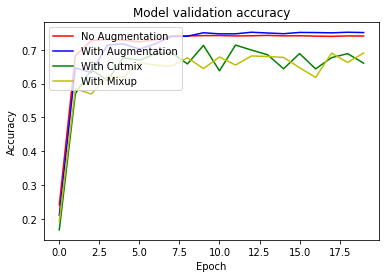

In [147]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Cutmix','With Mixup'], loc='upper left')
plt.show()

조금 더 확대해 살펴봅시다

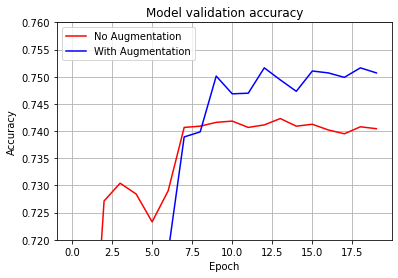

In [152]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

Augmentation을 준 모델이 accuracy가 더 높습니다~!

## **5. Augmentation에 의한 모델 성능 비교**
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

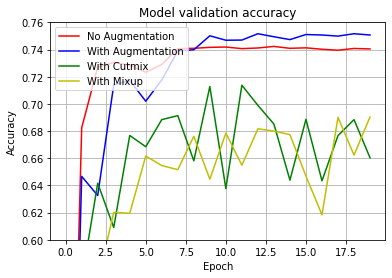

In [153]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Cutmix','With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()

In [154]:
print(f"No Augmentation best accuracy : {round(max(history_resnet50_no_aug.history['val_accuracy']), 3)}")
print(f"With Augmentation best accuracy : {round(max(history_resnet50_aug.history['val_accuracy']), 3)}")
print(f"With Augmentation with Cutmix best accuracy : {round(max(history_resnet50_aug_cutmix.history['val_accuracy']), 3)}")
print(f"With Augmentation with mixup best accuracy : {round(max(history_resnet50_aug_mixup.history['val_accuracy']), 3)}")

No Augmentation best accuracy : 0.742
With Augmentation best accuracy : 0.752
With Augmentation with Cutmix best accuracy : 0.714
With Augmentation with mixup best accuracy : 0.69


|  | No Augmentation | With Augmentation |
|:---:|:---:|:---:|
| No CutMix, MixUp | 0.742 | 0.752 |
| With CutMix |  | 0.714 |
| With MixUp |  | 0.69 |

---

### **🌮 루브릭**
| **평가문항** 	| **상세기준** 	| **수행결과** 	|
|:---:	|:---:	|:---:	|
| 1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? 	| CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다. 	| O 	|
| 2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? 	| 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음 	| O 	|
| 3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? 	| 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다. 	| O 	|

### **✍ 회고**

* 정말 바보같은 실수로 거의 이틀을 날린것 같다.. img_size=224로 지정해놓고 정작 함수내에는 image_size 라고 적어놔서...... 사이즈가 계속 안맞다고 부르짖었는데 나는 다른데에 문제가 있나.. 애꿎은 tf.cast를 바꿔보고 힘들었따...

### **📚 참고문헌**

* [[kaggle]CutMix and MixUp on GPU/TPU](https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook)